In [1]:
import numpy as np

class Network:
    def __init__(self, num_nodes, interactions_per_node, hawk_dove_payoff, memory_cost, initial_memory_poisson, initial_aggression):
        self.num_nodes = num_nodes # a number
        self.interactions_per_node = interactions_per_node # a number
        self.payoff_matrix = hawk_dove_payoff #[hawk-hawk winner, hawk-hawk loser, hawk-dove hawk, hawk-dove dove; dove-dove dove]
        self.memory_cost = memory_cost #metabolic cost of each memory slot, paid after each interaction
        self.nodes = [] #list of Node objects of the network
        self.history = [] #after every refresh, save the average fitness, memory, and aggression
        sizes = np.random.random_sample(self.num_nodes) #generate uniform sample of sizes list, each node has a 'size'
        memory = np.random.poisson(initial_memory_poisson, size = self.num_nodes) #initial memory is a poisson distribution
        aggression = np.random.normal(initial_aggression, 0.05, self.num_nodes) #initial aggression is a Gaussian(loc, 0.05)
        #create iniital Nodes
        for i in range(self.num_nodes):
            self.nodes.append(Node(sizes[i], memory[i], aggression[i]))
            
    def interact(self):    
        #each node has the same probability of having an interaction, with all nodes equally likely to interact with all other nodes
        indices = np.random.choice(self.num_nodes, size = (self.interactions_per_node*self.num_nodes, 2)) #pick 2 possible nodes to interact
        for i in range(self.interactions_per_node*self.num_nodes):
            ind1 = indices[i][0]
            ind2 = indices[i][1]
            if ind1 != ind2: #check for interaction with self
                self.hawk_dove(self.nodes[ind1], self.nodes[ind2]) 
            else: #assign new partner if assigned an interaction with self
                ind2 = np.random.choice([index for index in np.arange(self.num_nodes) if index != ind1])
                self.hawk_dove(self.nodes[ind1], self.nodes[ind2])
                
    def hawk_dove(self, node1, node2):
        #increment the total number of interactions a Node has had over its lifetime
        node1.num_interactions += 1
        node2.num_interactions += 1
        
        #these numbers are used to determine if an ignorant Node plays hawk or dove
        rand_nums = np.random.random_sample(2)
        
        #If a Node remembers beating a bigger Node than its current partner, it plays hawk;
        #If a Node remembers losing to a smaller Node than its current partner, it plays dove;
        #Otherwise, we label the Node as ignorant, its probability of playing hawk is its aggression
        #Victories are stored in memory as 1 and losses as 0, if there was not a hawk-hawk interaction,
        #the interaction still uses a memory slot, but it is recorded as None.
        
        if node2.size < node1.min_size: #player 1 plays hawk
            if node1.size < node2.min_size: #player 2 plays hawk
                if node1.size > node2.size: #player 1 wins
                    node1.fitness += self.payoff_matrix[0]
                    node2.fitness += self.payoff_matrix[1]
                    node1.add_memory(node2.size, 1)
                    node2.add_memory(node1.size, 0)
                else: #player 2 wins
                    node2.fitness += self.payoff_matrix[0]
                    node1.fitness += self.payoff_matrix[1]
                    node1.add_memory(node2.size, 0)
                    node2.add_memory(node1.size, 1)
            elif node1.size > node2.max_size: #player 2 plays dove
                node1.fitness += self.payoff_matrix[2]
                node2.fitness += self.payoff_matrix[3]
                node1.add_memory(node2.size, None)
                node2.add_memory(node1.size, None)
            else: #player 2 ignorant
                if node2.aggression > rand_nums[1]: #player 2 plays ignorant hawk if level of agression of the player is high 'enough' -> maybe we want to change this?
                    if node1.size > node2.size: #player 1 wins
                        node1.fitness += self.payoff_matrix[0]
                        node2.fitness += self.payoff_matrix[1]
                        node1.add_memory(node2.size, 1)
                        node2.add_memory(node1.size, 0)
                    else: #player 2 wins
                        node2.fitness += self.payoff_matrix[0]
                        node1.fitness += self.payoff_matrix[1]
                        node1.add_memory(node2.size, 0)
                        node2.add_memory(node1.size, 1)
                else: #player 2 plays ignorant dove
                    node1.fitness += self.payoff_matrix[2]
                    node2.fitness += self.payoff_matrix[3]
                    node1.add_memory(node2.size, None)
                    node2.add_memory(node1.size, None)
                    
        elif node2.size > node1.max_size: #player 1 plays dove
            if node1.size < node2.min_size: #player 2 plays hawk
                node2.fitness += self.payoff_matrix[2]
                node1.fitness += self.payoff_matrix[3]
            elif node1.size > node2.max_size: #player 2 plays dove
                node1.fitness += self.payoff_matrix[4]
                node2.fitness += self.payoff_matrix[4]              
            else: #player 2 ignorant
                if node2.aggression > rand_nums[1]: #player 2 plays ignorant hawk
                    node2.fitness += self.payoff_matrix[2]
                    node1.fitness += self.payoff_matrix[3]
                else: #player 2 plays ignorant dove
                    node1.fitness += self.payoff_matrix[4]
                    node2.fitness += self.payoff_matrix[4]
            node1.add_memory(node2.size, None)
            node2.add_memory(node1.size, None)
            
        else: #player 1 ignorant
            if node1.aggression > rand_nums[0]: #player 1 plays ignorant hawk
                if node1.size < node2.min_size: #player 2 plays hawk
                    if node1.size > node2.size: #player 1 wins
                        node1.fitness += self.payoff_matrix[0]
                        node2.fitness += self.payoff_matrix[1]
                        node1.add_memory(node2.size, 1)
                        node2.add_memory(node1.size, 0)
                    else: #player 2 wins
                        node2.fitness += self.payoff_matrix[0]
                        node1.fitness += self.payoff_matrix[1]
                        node1.add_memory(node2.size, 0)
                        node2.add_memory(node1.size, 1)
                elif node1.size > node2.max_size: #player 2 plays dove
                    node1.fitness += self.payoff_matrix[2]
                    node2.fitness += self.payoff_matrix[3]
                    node1.add_memory(node2.size, None)
                    node2.add_memory(node1.size, None)
                else: #player 2 ignorant
                    if node2.aggression > rand_nums[1]: #player 2 plays ignorant hawk
                        if node1.size > node2.size: #player 1 wins
                            node1.fitness += self.payoff_matrix[0]
                            node2.fitness += self.payoff_matrix[1]
                            node1.add_memory(node2.size, 1)
                            node2.add_memory(node1.size, 0)
                        else: #player 2 wins
                            node2.fitness += self.payoff_matrix[0]
                            node1.fitness += self.payoff_matrix[1]
                            node1.add_memory(node2.size, 0)
                            node2.add_memory(node1.size, 1)
                    else: #player 2 plays ignorant dove
                        node1.fitness += self.payoff_matrix[2]
                        node2.fitness += self.payoff_matrix[3]
                        node1.add_memory(node2.size, None)
                        node2.add_memory(node1.size, None)
            else: #player 1 plays ignorant dove
                if node1.size < node2.min_size: #player 2 plays hawk
                    node2.fitness += self.payoff_matrix[2]
                    node1.fitness += self.payoff_matrix[3]
                elif node1.size > node2.max_size: #player 2 plays dove
                    node1.fitness += self.payoff_matrix[4]
                    node2.fitness += self.payoff_matrix[4]
                else: #player 2 ignorant
                    if node2.aggression > rand_nums[1]: #player 2 plays ignorant hawk
                        node2.fitness += self.payoff_matrix[2]
                        node1.fitness += self.payoff_matrix[3]
                    else: #player 2 plays ignorant dove
                        node1.fitness += self.payoff_matrix[4]
                        node2.fitness += self.payoff_matrix[4]
                node1.add_memory(node2.size, None)
                node2.add_memory(node1.size, None)
        
        #Nodes pay a cost per memory slot after every interaction
        node1.fitness -= len(node1.size_memory)*self.memory_cost
        node2.fitness -= len(node2.size_memory)*self.memory_cost
        
        #Fitness cannot be negative
        if node1.fitness < 0:
            node1.fitness = 0
        if node2.fitness < 0:
            node2.fitness = 0
        
        return
    
    def refresh_network(self):
        #create new Nodes to fully replace the existing network
        fitness = np.array([node.fitness for node in self.nodes]) #get fitness of Nodes
        mean_fitness = np.mean(fitness)
        fitness = fitness/np.sum(fitness) #fitness values are now normalized
        reproducing_node_index = np.random.choice(self.num_nodes, self.num_nodes, p = fitness) #random weighted choice based on fitness, select num_nodes nodes each having a probability egal to the normalized fitness
        reproducing_node_memory = np.array([len(self.nodes[index].size_memory) for index in reproducing_node_index]) #memory of new nodes is same as parent
        reproducing_node_aggression = np.array([self.nodes[index].aggression for index in reproducing_node_index]) #aggression of new nodes, same as parent
        
        #record means to see results
        self.history.append([mean_fitness, np.mean(reproducing_node_memory), np.mean(reproducing_node_aggression)])
        
        #add mutations
        memory_mutations = np.random.standard_normal(self.num_nodes).astype(int) #mutation offsets for memory, integers from Gaussian(0,1)
        aggression_mutations = np.random.normal(0, 0.01, self.num_nodes).astype('float64') #mutation offsets for aggression, Gaussian(0, 0.05) values
        reproducing_node_memory += memory_mutations #mutate memory
        reproducing_node_aggression += aggression_mutations #mutate aggression
        sizes = np.random.random_sample(self.num_nodes) #generate uniform sample of sizes
        
        del self.nodes[:] #clear current nodes
        for i in range(self.num_nodes): #create new nodes
            self.nodes.append(Node(sizes[i], reproducing_node_memory[i], reproducing_node_aggression[i]))
        
class Node:
    def __init__(self, size, memory_length, aggression):
        self.size = size
        self.num_interactions = 0
        self.fitness = 0.0
        self.min_size = 0.0 #size of the largest fish you have beaten
        self.max_size = 1.0 #size of smallest fish you have lost to you
        
        #check that memory is positive
        if memory_length < 0:
            memory_length = 0
        self.size_memory = [None]*int(memory_length) #memories the size of the opponent
        self.outcome_memory = [None]*int(memory_length) #memories the outcome of the fight (or interaction ???)
        
        #check that aggression is between 0 and 1
        if aggression > 1.0:
            self.aggression = 1.0
        elif aggression < 0.0:
            self.aggression = 0.0
        else: self.aggression = aggression
            
    def add_memory(self, new_size, outcome):
        
        #if outcome is none there was no fight (no Hawk Hawk)
        if len(self.size_memory) == 0:
            return
        
        #Update the Node's perception of the biggest partner it has beaten and smallest partner it has lost to if the new memory
        #changes these values (min, max).
        if self.num_interactions > len(self.size_memory): #memory is full
            self.outcome_memory.append(outcome) #gain memory
            self.size_memory.append(new_size)
            if outcome == 1: #won fight
                if new_size > self.min_size: #check if new memory changes min
                    self.min_size = new_size #set new min
                    self.size_memory.pop(0) #lose memory
                    self.outcome_memory.pop(0)
                elif self.size_memory[0] == self.min_size: #check if losing min memory
                    self.size_memory.pop(0) #lose memory
                    self.outcome_memory.pop(0)
                    #set new min
                    self.min_size = max([self.size_memory[i] for i in range(len(self.outcome_memory)) if self.outcome_memory[i] == 1])
                else: #lose memory
                    self.size_memory.pop(0)
                    self.outcome_memory.pop(0)                
            elif outcome == 0: #lost fight
                if new_size < self.max_size:
                    self.max_size = new_size #set new max
                    self.size_memory.pop(0) #lose memory
                    self.outcome_memory.pop(0)
                elif self.size_memory[0] == self.max_size: #check if losing max memory
                    self.size_memory.pop(0) #lose memory
                    self.outcome_memory.pop(0)
                    #set new max
                    self.max_size = min([self.size_memory[i] for i in range(len(self.outcome_memory)) if self.outcome_memory[i] == 0])
                else: #lose memory
                    self.size_memory.pop(0)
                    self.outcome_memory.pop(0)                      
            else: #no fight, lose memory
                self.size_memory.pop(0)
                self.outcome_memory.pop(0)
        else: #memory is not full
            if outcome == 1: #won fight
                if new_size > self.min_size: #check if new min
                    self.min_size = new_size
            elif outcome == 0: #lost fight
                if new_size < self.max_size: #check if new max
                    self.max_size = new_size
                    
            #gain memory
            self.size_memory[self.num_interactions-1] = new_size
            self.outcome_memory[self.num_interactions-1] = outcome


In [2]:
#Simulation parameters        
num_nodes = 50
interactions_per_node = 100
hawk_dove_payoff = [0.5, -1.5, 1, 0, 0.5, 0.5]
memory_cost = 0.01
initial_memory_poisson = 0.25
initial_aggression = 0.5

#Create the initial Network
my_network = Network(num_nodes, interactions_per_node, hawk_dove_payoff, memory_cost, initial_memory_poisson, initial_aggression)
for i in range(5000): #simulate this many generations
    my_network.interact()
    my_network.refresh_network()
print('done')

done


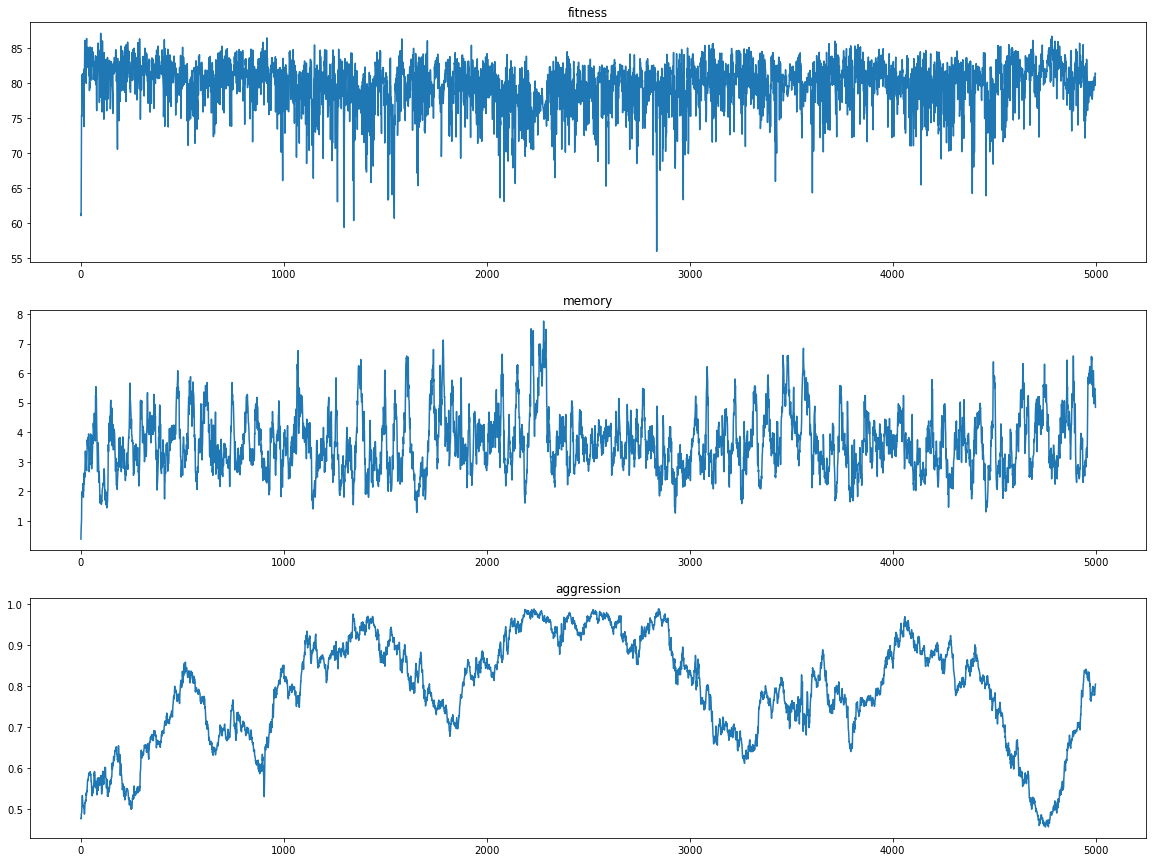

In [3]:
import matplotlib.pyplot as plt

#graph results of the simulation

t = len(my_network.history)
fitness_history = [my_network.history[i][0] for i in range(t)]
memory_history = [my_network.history[i][1] for i in range(t)]
aggression_history = [my_network.history[i][2] for i in range(t)]
x = np.arange(t)
fig, axes = plt.subplots(3,1, figsize = (20, 15))
axes[0].plot(x, fitness_history)
axes[0].set_title('fitness')
axes[1].plot(x, memory_history)
axes[1].set_title('memory')
axes[2].plot(x, aggression_history)
axes[2].set_title('aggression')
plt.show()